In [1]:
# import required libraries
#!conda install nltk
import numpy as np
import pandas as pd
import nltk
import re
import scipy.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline

#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context
nltk.download('punkt')

#!pip3 install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm_notebook as tqdm

[nltk_data] Downloading package punkt to /Users/mathilda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
with open('pride_and_prejudice.txt','r') as f:
#with open('Pride and Prejudice.txt','r') as f:
    full_txt = f.read().strip('\n').replace("\''","'")
    # clean the unnecessary txt
    full_txt = full_txt.replace('_','').replace('make by 拉米网（www.lami.fun）','') 

In [3]:
# chapter-wise
chapter_txt = full_txt.split('Chapter ')[1:] #len(chapter_txt)=61
cleaned_chapter = []
for chapter in chapter_txt:
    cleaned_chapter.append(chapter[1:].replace('\n',''))
len(cleaned_chapter)

61

In [4]:
# sentence-wise
cleaned_sentence = []
from nltk.tokenize import sent_tokenize
cleaned_sentence = [sent_tokenize(chapter) for chapter in cleaned_chapter]
cleaned_sentence = [x for y in cleaned_sentence for x in y]
len(cleaned_sentence)

5584

In [5]:
CHARACTER_LIST = [
    'Darcy', 'Bingley','Elizabeth','Caroline','Lydia','Catherine','Georgianna','Collins','Charlotte','Wickham','Miss de Bourgh','Colonel','Mr. Bennet','Mrs. Bennet'
]

NICKNAME_LIST = [
    'Lizzy','Kitty','Miss Lucas','Miss Bingley','Miss Darcy'
]

MATCH = [(2,0),(3,1),(8,2),(3,3),(6,4)]



num_people = len(CHARACTER_LIST)

In [6]:
def name_plus_nick(list_1,list_2):
    co_list = []
    len_1 = len(list_1)
    for i in range(len_1):
        if list_1[i]+list_2[i] == 0:
            co_list.append(0)
        else:
            co_list.append(1)
    return co_list

In [7]:
def find_interaction(sections):
    Characters = {}
    occurrence = []
    occurrence_2 = []
    for person in CHARACTER_LIST:
        vector = []
        for section in sections:
            if person in section:
                vector.append(1)
            else:
                vector.append(0)
        occurrence.append(np.array(vector))
        Characters[person] = np.array(vector)
    
    for person in CHARACTER_LIST:
        vector = []
        for section in sections:
            if person in section:
                vector.append(1)
            else:
                vector.append(0)
        occurrence_2.append(np.array(vector))
    
    for match in MATCH:
        name = match[0]
        nick = match[1]
        occur_new = name_plus_nick(occurrence[name],occurrence_2[nick])
        occurrence[name] = occur_new
        person = CHARACTER_LIST[name]
        Characters[person] = occur_new

    occurrence_matrix = pd.DataFrame(occurrence) # num of people * num of sections 15*61
    co_occur = pd.DataFrame(np.dot(occurrence_matrix,occurrence_matrix.T))
    co_occur = co_occur / np.linalg.norm(co_occur, ord = 1, axis = 0)
    return co_occur, occurrence_matrix, Characters

In [8]:
def text_rank(section_name, section):
    co_occur, occurrence, Characters = find_interaction(section)
    #print(co_occur)
    P = co_occur
    alpha = 0.85
    P = alpha* co_occur + (1-alpha)*np.ones((num_people,num_people))/num_people
    
    # interation PageRank
    rank_inter = np.ones((num_people, 1))/num_people
    for i in range(100000):
        rank_inter = np.dot(P,rank_inter)
    rank_inter = rank_inter.reshape(-1,)
    
    text_rank = rank_inter[np.argsort(rank_inter)[::-1]].tolist()
    text_chara = [CHARACTER_LIST[i] for i in np.argsort(rank_inter)[::-1].tolist()]
    Characters_sort = sorted(Characters.items(), key=lambda x: sum(x[1]), reverse = True)
    occur_rank = [sum(character[1]) for character in Characters_sort]
    occur_chara = [character[0] for character in Characters_sort]
  
    rank_table = pd.DataFrame([text_chara, occur_chara]).T
    rank_table.columns = ['TextRank','Occurrence Rank']
    rank_table.index = np.arange(1,num_people+1).tolist()
    print(rank_table)
    
    x = np.arange(len(CHARACTER_LIST)).tolist()
    plt.bar(x, text_rank)
    plt.xticks(x, text_chara, rotation=50)
    plt.title(f'PageRank by {section_name} (Descending)')

    plt.show()
    return occurrence

          TextRank Occurrence Rank
1        Elizabeth       Elizabeth
2        Charlotte       Charlotte
3            Darcy           Darcy
4         Caroline        Caroline
5          Bingley         Bingley
6       Georgianna         Wickham
7            Lydia         Collins
8          Collins           Lydia
9          Wickham      Georgianna
10       Catherine     Mrs. Bennet
11     Mrs. Bennet       Catherine
12      Mr. Bennet      Mr. Bennet
13         Colonel         Colonel
14  Miss de Bourgh  Miss de Bourgh


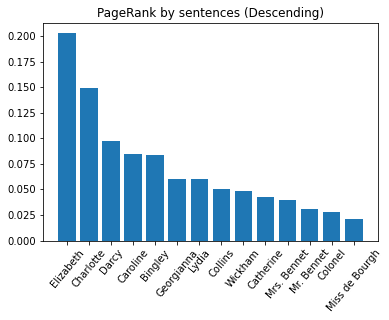

In [9]:
occur_sentence = text_rank('sentences', cleaned_sentence)

In [15]:
occur_sentence.index = CHARACTER_LIST
occur_sentence.to_csv('./character_sentence.csv') # character * sentences

In [21]:
analyzer = SentimentIntensityAnalyzer()
chapter_ends = [0]
sentiments = {'compound': [], 'neg': [], 'neu': [], 'pos': []}
for chapter in tqdm(cleaned_chapter):
    sentence_list = nltk.tokenize.sent_tokenize(chapter)
    chapter_ends.append(chapter_ends[-1]+len(sentence_list))
    
    for sentence in sentence_list:
        vs = analyzer.polarity_scores(sentence)
        sentiments['compound'].append(vs['compound'])
        sentiments['neg'].append(vs['neg'])
        sentiments['neu'].append(vs['neu'])
        sentiments['pos'].append(vs['pos'])
pd.DataFrame(chapter_ends).to_csv('./chapter_ends.csv')

<ipython-input-21-09d64754fde9>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chapter in tqdm(cleaned_chapter):


In [16]:
sentiment_matrix = pd.DataFrame(sentiments).T 
sentiment_matrix.to_csv('./sentiment_sentence.csv') # sentiment * sentences